# imports

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import torch.nn as nn

from sklearn.impute import KNNImputer # to deal with missing values

from sklearn.preprocessing import MinMaxScaler # to rescale the data

from seaborn import histplot

# loading the data

and get basic information about it

In [2]:
# loading the data
train_original = pd.read_csv("/kaggle/input/song-popularity-prediction/train.csv")
test_original = pd.read_csv("/kaggle/input/song-popularity-prediction/test.csv")
sample_submission = pd.read_csv("/kaggle/input/song-popularity-prediction/sample_submission.csv")

In [3]:
train_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                40000 non-null  int64  
 1   song_duration_ms  35899 non-null  float64
 2   acousticness      36008 non-null  float64
 3   danceability      35974 non-null  float64
 4   energy            36025 non-null  float64
 5   instrumentalness  36015 non-null  float64
 6   key               35935 non-null  float64
 7   liveness          35914 non-null  float64
 8   loudness          36043 non-null  float64
 9   audio_mode        40000 non-null  int64  
 10  speechiness       40000 non-null  float64
 11  tempo             40000 non-null  float64
 12  time_signature    40000 non-null  int64  
 13  audio_valence     40000 non-null  float64
 14  song_popularity   40000 non-null  int64  
dtypes: float64(11), int64(4)
memory usage: 4.6 MB


In [4]:
for c in train_original.columns:
    c_unique =  np.unique(train_original[c].dropna()) # dropping the nan then counting the number of unique values
    print(c, len(c_unique))

id 40000
song_duration_ms 31586
acousticness 36004
danceability 35972
energy 36021
instrumentalness 35999
key 12
liveness 35911
loudness 36038
audio_mode 2
speechiness 39999
tempo 39993
time_signature 4
audio_valence 39998
song_popularity 2


So key, audio_mode and time_signature are categorical features. We are going to use embeddings to deal with them and harness the power of multi-layer perceptron. We inform the train_original dataframe that those features are categorical in the following cell. 

In [5]:
to_categorical = {'key': 'category', 'audio_mode':'category', 'time_signature':'category'}

for k in to_categorical:
    train_original[k].astype('category')
    test_original[k].astype('category')
#train_original.info()


In [6]:
train_original.columns

Index(['id', 'song_duration_ms', 'acousticness', 'danceability', 'energy',
       'instrumentalness', 'key', 'liveness', 'loudness', 'audio_mode',
       'speechiness', 'tempo', 'time_signature', 'audio_valence',
       'song_popularity'],
      dtype='object')

# dealing with missing values using the KNNImputer of sklearn

1. We will first rescale all the numerical columns to be between -0.5 and 0.5 to have the same order of magnitude when using the KNNImputer.

2. Then we use the KNNImputer to fit the numerical columns using the mean of the nearest neighbors.

3. Then we use the KNNImputer to fit the categorical values using the most represented category. 

In [7]:
# rescaling
rescaled_train = train_original.copy()
rescaled_test = test_original.copy()
ignore_columns = ['id', 'audio_mode', 'time_signature','song_popularity']
scaler_dict = {}

for column in train_original.columns:
    if column not in ignore_columns:
        print(column)
        scaler = MinMaxScaler(feature_range=(-0.5,0.5)) 
        transformed_column = scaler.fit_transform(train_original[column].values.reshape(40000,1))
        rescaled_train[column] = transformed_column.squeeze()
        rescaled_test[column] = scaler.transform(test_original[column].values.reshape(-1,1))
        scaler_dict[column] = scaler
        


song_duration_ms
acousticness
danceability
energy
instrumentalness
key
liveness
loudness
speechiness
tempo
audio_valence


In [8]:
scaler_dict

{'song_duration_ms': MinMaxScaler(feature_range=(-0.5, 0.5)),
 'acousticness': MinMaxScaler(feature_range=(-0.5, 0.5)),
 'danceability': MinMaxScaler(feature_range=(-0.5, 0.5)),
 'energy': MinMaxScaler(feature_range=(-0.5, 0.5)),
 'instrumentalness': MinMaxScaler(feature_range=(-0.5, 0.5)),
 'key': MinMaxScaler(feature_range=(-0.5, 0.5)),
 'liveness': MinMaxScaler(feature_range=(-0.5, 0.5)),
 'loudness': MinMaxScaler(feature_range=(-0.5, 0.5)),
 'speechiness': MinMaxScaler(feature_range=(-0.5, 0.5)),
 'tempo': MinMaxScaler(feature_range=(-0.5, 0.5)),
 'audio_valence': MinMaxScaler(feature_range=(-0.5, 0.5))}

In [9]:
rescaled_train

,id,song_duration_ms,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,audio_mode,speechiness,tempo,time_signature,audio_valence,song_popularity
0,0,-0.098011,0.107912,0.389823,0.180564,-0.494074,0.409091,NaN,0.348218,0,-0.376293,0.113149,4,0.214697,0
1,1,NaN,-0.436583,0.254874,0.303926,-0.495005,0.227273,-0.106166,0.360450,1,-0.294214,-0.240960,3,0.191796,1
2,2,-0.140450,NaN,-0.341841,0.253974,-0.498422,-0.045455,-0.362495,0.369579,0,-0.431798,0.242357,3,-0.091603,0
3,3,-0.018822,-0.034488,0.092741,0.032317,-0.495364,-0.500000,-0.435456,0.275409,0,-0.462336,-0.075706,3,-0.063796,0
4,4,-0.198912,-0.030449,NaN,0.213124,-0.494044,0.409091,-0.435373,0.442167,0,-0.434611,-0.118909,4,0.221306,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,39995,-0.044775,NaN,0.272016,-0.007485,-0.493229,-0.500000,-0.359309,0.244680,0,-0.384558,0.176014,3,-0.336734,0
39996,39996,-0.144943,-0.424882,0.188666,0.355912,-0.494792,-0.045455,-0.408351,0.278440,0,-0.181973,-0.190475,3,0.270173,0
39997,39997,-0.209834,0.325874,-0.100180,-0.217355,NaN,0.409091,-0.420169,0.035820,0,-0.470258,-0.261309,3,-0.336944,1
39998,39998,-0.138937,NaN,-0.147626,NaN,-0.495613,-0.409091,-0.183394,0.378855,1,-0.428473,-0.004788,3,0.252686,0


In [10]:
train_original

,id,song_duration_ms,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,audio_mode,speechiness,tempo,time_signature,audio_valence,song_popularity
0,0,212990.0,0.642286,0.856520,0.707073,0.002001,10.0,NaN,-5.619088,0,0.082570,158.386236,4,0.734642,0
1,1,NaN,0.054866,0.733289,0.835545,0.000996,8.0,0.436428,-5.236965,1,0.127358,102.752988,3,0.711531,1
2,2,193213.0,NaN,0.188387,0.783524,-0.002694,5.0,0.170499,-4.951759,0,0.052282,178.685791,3,0.425536,0
3,3,249893.0,0.488660,0.585234,0.552685,0.000608,0.0,0.094805,-7.893694,0,0.035618,128.715630,3,0.453597,0
4,4,165969.0,0.493017,NaN,0.740982,0.002033,10.0,0.094891,-2.684095,0,0.050746,121.928157,4,0.741311,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,39995,237799.0,NaN,0.748942,0.511234,0.002913,0.0,0.173803,-8.853673,0,0.078060,168.262924,3,0.178159,0
39996,39996,191119.0,0.067488,0.672830,0.889685,0.001225,5.0,0.122924,-7.798993,0,0.188607,110.684544,3,0.790626,0
39997,39997,160879.0,0.877431,0.409065,0.292671,NaN,10.0,0.110664,-15.378585,0,0.031294,99.556074,3,0.177947,1
39998,39998,193918.0,NaN,0.365738,NaN,0.000339,1.0,0.356308,-4.661977,1,0.054096,139.857384,3,0.772978,0


# comment : 
The only categorical feature having missing values is 'key'. And since 'audio_mode' takes only two values, 0 and 1, it does not matter if it is ordinal or not.
Regarding the 'time_signature', we assume it is ordinal and hence can be used to compute distance. Furthermore, 'time_signature' takes only 4 values [2,3,4,5] and mostly takes value 3 and 4 and rarely 2 and 5.
So we are going to consider them as ordinale and use them to compute distances in the KNNImputer. 

<AxesSubplot:xlabel='time_signature', ylabel='Count'>

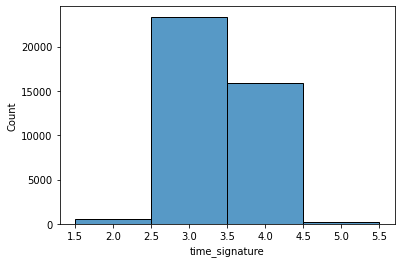

In [11]:
#unique, count = np.unique(train_original["time_signature"], return_counts=True)
#unique, count # change to histogram when sharing 
histplot(train_original["time_signature"], discrete=True)


### Imputing continuous values

In [12]:

imputer_continuous = KNNImputer(n_neighbors=15,weights='distance')
imputed_train = rescaled_train.copy()
imputed_test = rescaled_test.copy()
# let the imputation use the song_popularity column and add song_popularity to the test data but
# set it to 0.5 so that it does not contribute to the imputation. 
imputed_train = imputed_train.drop(columns='id') 
imputed_test = imputed_test.drop(columns='id')
imputed_test['song_popularity']= 0.5

imputed_train = pd.DataFrame(imputer_continuous.fit_transform(imputed_train), columns = imputed_train.columns)
imputed_test = pd.DataFrame(imputer_continuous.transform(imputed_test), columns = imputed_test.columns)



### Imputing the categorical value, 'key'

In [13]:
imputer_key = KNNImputer(n_neighbors=1)
imputed_train['key'] = train_original['key']
imputed_test['key'] = test_original['key']

#print(imputed_train.info())
temp = pd.DataFrame(imputer_key.fit_transform(rescaled_train.drop(columns='id')), columns = imputed_train.columns)
imputed_train['key'] = temp['key']
imputed_train.info()

rescaled_test['song_popularity']=0.5
temp = pd.DataFrame(imputer_key.transform(rescaled_test.drop(columns='id')), columns = imputed_train.columns)
imputed_test['key'] = temp['key']
imputed_test = imputed_test.drop(columns='song_popularity') # drop the song popularity column since we do not need it anymore
imputed_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   song_duration_ms  40000 non-null  float64
 1   acousticness      40000 non-null  float64
 2   danceability      40000 non-null  float64
 3   energy            40000 non-null  float64
 4   instrumentalness  40000 non-null  float64
 5   key               40000 non-null  float64
 6   liveness          40000 non-null  float64
 7   loudness          40000 non-null  float64
 8   audio_mode        40000 non-null  float64
 9   speechiness       40000 non-null  float64
 10  tempo             40000 non-null  float64
 11  time_signature    40000 non-null  float64
 12  audio_valence     40000 non-null  float64
 13  song_popularity   40000 non-null  float64
dtypes: float64(14)
memory usage: 4.3 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 13 

In [ ]:
#imputed_test.info(), rescaled_test.info(), imputed_train.info()

# Random Forest with the new data imputation 

In [15]:
from sklearn.ensemble import RandomForestClassifier

rf_classifier = RandomForestClassifier(max_depth = 11,
                                       bootstrap=True,
                                       n_estimators=500,
                                       min_samples_leaf=11,
                                       min_samples_split=11,
                                       oob_score=True, 
                                       n_jobs=-1,
                                       class_weight='balanced_subsample',
                                       max_samples=2000
                                      )

In [16]:
X = imputed_train.loc[:,imputed_train.columns!='song_popularity']
y = imputed_train['song_popularity']
                             
rf_classifier.fit(X,y)

RandomForestClassifier(class_weight='balanced_subsample', max_depth=11,
                       max_samples=2000, min_samples_leaf=11,
                       min_samples_split=11, n_estimators=500, n_jobs=-1,
                       oob_score=True)

In [17]:
test_pred = rf_classifier.predict_proba(imputed_test)

In [18]:
submission = pd.read_csv("../input/song-popularity-prediction/sample_submission.csv")
submission['song_popularity'] = test_pred[:,1]
submission.to_csv("submission.csv", index=False)